In [2]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
import math

In [3]:
def forward_selection(data, significance_level=0.01): #Selecting significant features, removing TEAM, CONF and W:G manually
  
  target = data["W:G"].to_numpy()
  features = data.columns.tolist()
  lowest_p_value = 0
  lowest_p_index = -1
  for i in range(len(features)):
    if (features[i] == "TEAM" or features[i] == "CONF" or features[i] == "W:G"):
      continue
    X = data.loc[:, features[i]]
    X = sm.add_constant(X)
    result = sm.OLS(target, X.astype(float)).fit()
    curr_p_value = result.pvalues[1]
    if lowest_p_index == -1 or lowest_p_value > curr_p_value:
        lowest_p_value = curr_p_value
        lowest_p_index = i

  removed_features = [data.loc[:, features.pop(lowest_p_index)].name]
  while (True):
      lowest_p_value = 0
      lowest_p_index = -1
      for i in range(len(features)):
        if (features[i] == "TEAM" or features[i] == "CONF" or features[i] == "W:G"):
          continue
        removed_features.append(features[i])
        X = data.loc[:, removed_features]
        X = sm.add_constant(X)
        result = sm.OLS(target, X.astype(float)).fit()
        removed_features.remove(features[i])
        curr_value = result.pvalues[len(result.pvalues) - 1]
        if lowest_p_index == -1 or lowest_p_value > curr_value:
            lowest_p_value = curr_value
            lowest_p_index = i
    
      if (lowest_p_value >= significance_level):
        return removed_features
      else:
        if (len(features) == 0):
            break
        removed_features.append(features.pop(lowest_p_index))
          
  return removed_features

In [4]:
def top_features(columns, size): # Return the most important features from forward selection
    return columns[:size]

In [5]:
def neural_network(X, y):
    model = MLPRegressor(max_iter=1000, solver='lbfgs', hidden_layer_sizes=(200,200))
    results = model.fit(X, y)
    return results

In [6]:
def display_summary(results):
    print(results.summary())

In [26]:
"""
Load the preprocessed dataset
"""
csv_name = 'cleaned_cbb.csv'
data = pd.read_csv(csv_name)

In [27]:
"""
Select the top features from forward selection
"""
fwd_sel = forward_selection(data)
important_features = top_features(fwd_sel, 5)
print(important_features)
X = data[important_features]
y = data["W:G"]

['ADJOE', 'WAB', 'EFG_O', 'TOR', 'ORB']


In [28]:
"""
Split the dataset into a training and testing set
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [32]:
"""
Generate test and training MSE data
"""
model = MLPRegressor(max_iter=1000, hidden_layer_sizes=(200,200))
train_mse = []
test_mse = []
for i in range(1000):
    model.partial_fit(X_train, y_train)
    train_mse.append(
metrics.mean_squared_error(y_train, model.predict(X_train)))
    test_mse.append(
metrics.mean_squared_error(y_test, model.predict(X_test)))

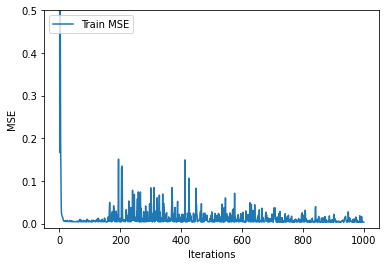

In [37]:
"""
Plot the learning curve of the model for Training MSE
"""
plt.plot(train_mse, label="Train MSE")
# plt.plot(test_mse, label="Test MSE")
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.ylim(-0.01, 0.5)
plt.legend(loc="upper left")
plt.show()

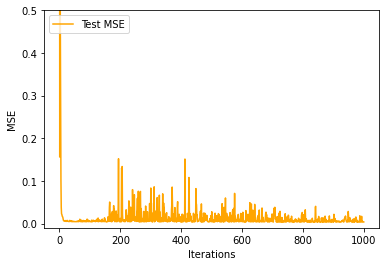

In [39]:
"""
Plot the learning curve of the model for Training MSE
"""
# plt.plot(train_mse, label="Train MSE")
plt.plot(test_mse, label="Test MSE", color="orange")
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.ylim(-0.01, 0.5)
plt.legend(loc="upper left")
plt.show()

In [29]:
"""
Perform supervised learning to predict the win rate using selected features with Stochastic Gradient Descent on a Neural Network (Multi-Layer Perceptron)
"""
model = neural_network(X_train, y_train)

In [11]:
"""
Training MSE
"""
metrics.mean_squared_error(y_test, model.predict(X_test))

0.0027985718481439554

In [12]:
"""
Test MSE
"""
metrics.mean_squared_error(y_test, model.predict(X_test))

0.0030954849803328526

In [13]:
"""
Training Coefficient of Determination
"""
model.score(X_train, y_train)

0.9137938702259525

In [14]:
"""
Test Coefficient of Determination
"""
model.score(X_test, y_test)

0.9029341976260374

In [17]:
"""
Calculate performance of the model on the train dataset
"""
predicted = model.predict(X_train)
print(metrics.r2_score(y_train, predicted))
metrics.explained_variance_score(y_train, predicted)

0.9137938702259525


0.9137938722081153

In [15]:
"""
Calculate performance of the model on a test dataset
"""
predicted = model.predict(X_test)
print(metrics.r2_score(y_test, predicted))
metrics.explained_variance_score(y_test, predicted)

0.9029341976260374


0.9029344230345149

In [16]:
"""
Figure out the top teams in the 2021 season
"""
csv_name = 'cbb21.csv'
data = pd.read_csv(csv_name)

X = data[important_features]

predicted = model.predict(X)
data['SCORE'] = predicted

order = list(reversed(np.argsort(predicted)))

# Print top 10 teams
print(data.loc[order[:10], ['TEAM', 'SCORE']])

                  TEAM     SCORE
54             Colgate  0.933563
49            Winthrop  0.903266
3              Gonzaga  0.898733
45               Drake  0.861598
31      Loyola Chicago  0.856498
1               Baylor  0.848474
2             Illinois  0.845733
317   Prairie View A&M  0.844561
56   Abilene Christian  0.840267
346            Belmont  0.837822


In [22]:
"""
Actual top teams in the 2021 season

Gonzaga
Houston
Kansas
Arizona
Baylor
Villanova
Tennessee
Texas Tech
Kentucky
Duke
"""

'\nActual top teams in the 2021 season\n\nGonzaga\nHouston\nKansas\nArizona\nBaylor\nVillanova\nTennessee\nTexas Tech\nKentucky\nDuke\n'